# Non congested latency

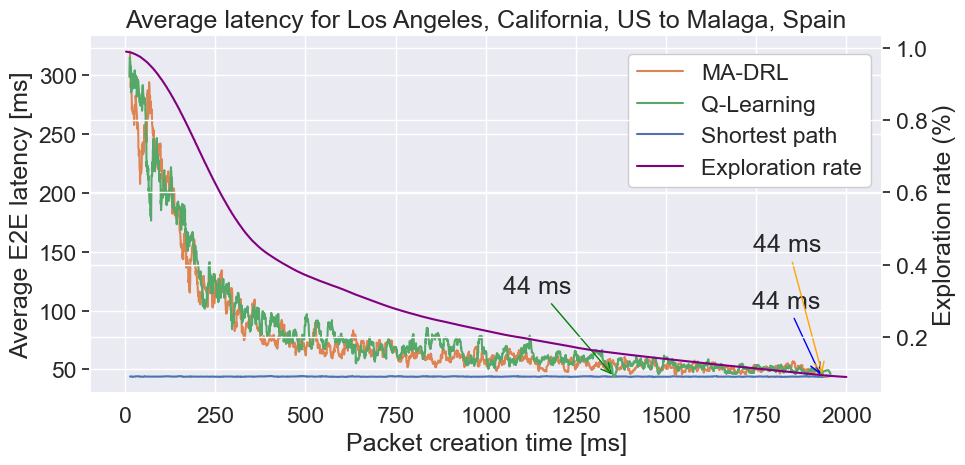

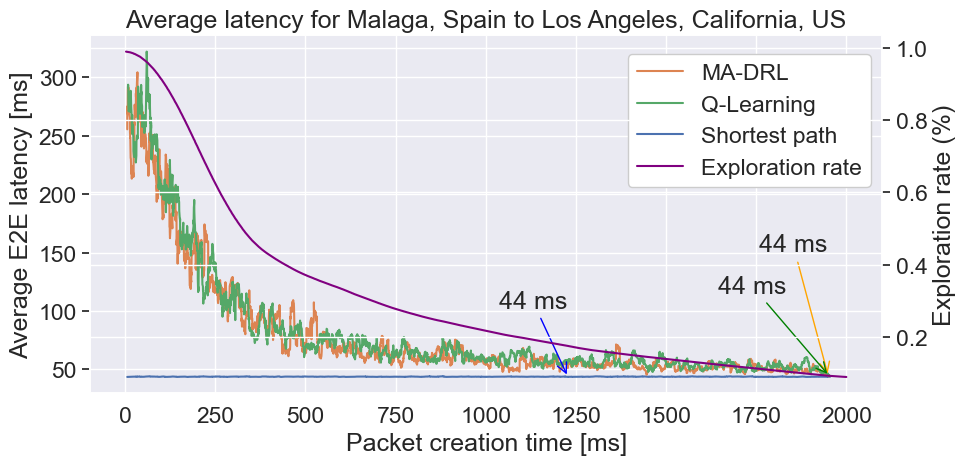

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def extract_block_index(block_id):
    return int(block_id.split('_')[-1])

def compare_latency_plots_with_epsilon_combined_legend(baseline, madrl, q_learning_path, epsilon_path, window_size=20, marker_size=50):
    sns.set(font_scale=1.5)

    # Load datasets
    df1_raw_base = pd.read_csv(baseline)
    df2_raw_madrl = pd.read_csv(madrl)
    q_learning_df = pd.read_csv(q_learning_path)
    epsilon_df = pd.read_csv(epsilon_path)

    # Convert to milliseconds
    for df in [df1_raw_base, df2_raw_madrl, q_learning_df]:
        df['Latency'] *= 1000
        df['Creation Time'] *= 1000
    epsilon_df['time'] *= 1000
    

    # Process latency data
    for df_raw in [df1_raw_base, df2_raw_madrl, q_learning_df]:
        df_raw['Block Index'] = df_raw['Block ID'].apply(extract_block_index)
        df_raw.sort_values(by=['Source', 'Destination', 'Block Index'], inplace=True)
        df_raw['Path'] = df_raw['Source'].astype(str) + ' -> ' + df_raw['Destination'].astype(str)
        df_raw['Latency_Rolling_Avg'] = df_raw.groupby('Path')['Latency'].transform(lambda x: x.rolling(window=window_size).mean())

    # Create subplot for each path
    unique_paths = df1_raw_base['Path'].unique()
    for path in unique_paths:
        plt.figure(figsize=(10, 5))

        # Filter data for the current path
        df1_path_base = df1_raw_base[df1_raw_base['Path'] == path]
        df2_path_madrl = df2_raw_madrl[df2_raw_madrl['Path'] == path]
        q_learning_path_df = q_learning_df[q_learning_df['Path'] == path]

        # Create twin axis for epsilon
        ax1 = plt.gca()
        ax2 = ax1.twinx()

        # Plot latency trends for all three policies
        sns.lineplot(x='Creation Time', y='Latency_Rolling_Avg', data=df1_path_base, label='Shortest path', markersize=marker_size, ax=ax1)
        sns.lineplot(x='Creation Time', y='Latency_Rolling_Avg', data=df2_path_madrl, label='MA-DRL', markersize=marker_size, ax=ax1)
        sns.lineplot(x='Creation Time', y='Latency_Rolling_Avg', data=q_learning_path_df, label='Q-Learning', markersize=marker_size, ax=ax1)

        # Plot epsilon trend
        sns.lineplot(x='time', y='epsilon', data=epsilon_df, color='purple', label='Exploration rate', ax=ax2)

        # Find and annotate minimum latency values for each dataset
        min_values = [
            (df1_path_base, 'blue', (-50, 50)),
            (df2_path_madrl, 'orange', (-50, 90)),
            (q_learning_path_df, 'green', (-80, 60))
        ]
        for df, color, offset in min_values:
            min_latency = df['Latency_Rolling_Avg'].min()
            min_pos = df['Creation Time'][df['Latency_Rolling_Avg'].idxmin()]
            ax1.annotate(f'{min_latency:.0f} ms', xy=(min_pos, min_latency), xytext=offset, textcoords='offset points', arrowprops=dict(arrowstyle='->', color=color))

            # Remove individual legends if they exist
            if ax1.get_legend() is not None:
                ax1.get_legend().remove()
            if ax2.get_legend() is not None:
                ax2.get_legend().remove()


            # Get handles and labels
            handles1, labels1 = ax1.get_legend_handles_labels()
            handles2, labels2 = ax2.get_legend_handles_labels()

            # Reorder the items in the legend
            # 'Shortest path' is the first item in labels1, 'MA-DRL' is the second, 'Q-Learning' is the third, and 'Exploration rate' is the first item in labels2
            handles_reordered = [handles1[1], handles1[2], handles1[0], handles2[0]]
            labels_reordered = [labels1[1], labels1[2], labels1[0], labels2[0]]

            # Create a new legend with the reordered handles and labels
            ax1.legend(handles_reordered, labels_reordered, loc='upper right', bbox_to_anchor=(1, 0.98), frameon=True, facecolor='white', framealpha=1)

        # Set plot titles and labels
        path = path.replace("->", "to")
        path = path.replace('Northwest Territories, ', '')
        plt.title(f'Average latency for {path}')
        ax1.set_xlabel('Packet creation time [ms]')
        ax1.set_ylabel('Average E2E latency [ms]')
        ax2.set_ylabel('Exploration rate (%)')

        plt.tight_layout()
        plt.savefig(f'{path}.png', dpi=300)
        plt.show()
        plt.close()

    sns.set(font_scale=1.0)

compare_latency_plots_with_epsilon_combined_legend('DataRate_Kepler.csv', 'AGP-LA_DRL_Kepler.csv', 'Q-Learning_Kepler.csv', 'epsilons_2_gateways_Kepler.csv', window_size=20, marker_size=5)
